# Интеллектуальный анализ данных – весна 2025
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.
* Если в задании есть вопрос на рассуждение, то за отсутствие ответа на него балл за задание будет снижен вполовину.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, Iterable, Optional
from string import punctuation, whitespace
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# import nltk
# nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.snowball import EnglishStemmer

# Поскольку стемминг будем использовать только для английского языка,
# можно использовать сразу EnglishStemmer вместо SnowballStemmer('english')

from scipy.sparse import csr_matrix, hstack as hstack_sparse

from operator import itemgetter

In [2]:
df = pd.read_csv('tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
32126,43320,88272,South Africa,13-04-2020,Shoprite Athlone has confirmed that one of its...,Positive
29387,39865,84817,"London, England",09-04-2020,Our COVID-19 strategy workbook\r\r\n\r\r\nHelp...,Extremely Positive
27150,37090,82042,NaN,07-04-2020,Normally I fill the neverending void in my hea...,Positive
14479,21387,66339,NaN,23-03-2020,#COVID2019 #Coronavirus #Corona Danish superma...,Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная или очень положительная эмоциональная окраска и 0 - если отрицательная или очень отрицательная.

In [3]:
df["Sentiment"] = df["Sentiment"].str.lower().str.contains("positive").astype(np.int8)

Сбалансированы ли классы?

In [4]:
df["Sentiment"].value_counts()

Sentiment
1    18046
0    15398
Name: count, dtype: int64

In [5]:
pos = (df["Sentiment"] == 1).sum()
neg = (df["Sentiment"] == 0).sum()

np.abs(pos - neg) / np.min((pos, neg))

np.float64(0.17197038576438498)

**Ответ:** разница в числе объектов с разными целевыми классами не превышает 18%, поэтому можно считать, что классы сбалансированы.

Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33444 entries, 0 to 33443
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       33444 non-null  int64 
 1   ScreenName     33444 non-null  int64 
 2   Location       26395 non-null  object
 3   TweetAt        33444 non-null  object
 4   OriginalTweet  33444 non-null  object
 5   Sentiment      33444 non-null  int8  
dtypes: int64(2), int8(1), object(3)
memory usage: 1.3+ MB


Пропуски есть только в столбце `Location`

In [7]:
df["Location"] = df["Location"].fillna("Unknown")

Разделите данные на обучающие и тестовые в соотношении 7 : 3 и укажите `random_state=0`

In [8]:
train, test = train_test_split(
    df, test_size=0.3, shuffle=True, random_state=0,
)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведения токенов в нижний регистр.

In [9]:
dictionary = Counter(
    train["OriginalTweet"].str.translate(
        str.maketrans(dict.fromkeys(whitespace, ' '))
    ).str.lower().str.split(' ').explode()

    # train["OriginalTweet"].str.lower().str.split(' ').explode()

    # Если для split() указать параметр sep=' ', то в качестве токенов будут добавлены
    # пустая строка '' и переносы строки '\n' и '\r', которые не являются валидными словами,
    # поэтому все пробельные символы сначала заменяются на пробелы во всех строках
)

# И затем можно убрать все вхождения пустых строк, т.к. они точно не несут смысловой нагрузки
del dictionary['']

Какой размер словаря получился?

In [10]:
print(f"There are {len(dictionary)} tokens in the dictionary.")

There are 79714 tokens in the dictionary.


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе.

In [11]:
def print_formatted_kv_pairs(
        pairs: Optional[Iterable[Tuple[str, int]] | Iterable[Tuple[str, float]] | np.ndarray] = None,
        *,
        keys: Optional[Iterable[str] | np.ndarray] = None,
        values: Optional[Iterable[int] | Iterable[float] | np.ndarray] = None,
    ) -> None:

    """
    Вспомогательная функция для печати пар ключ-значение в удобном формате.

    :param pairs: пары ключ-значение, которые нужно вывести на экран (обычно строка-число)
    :param keys: ключи пар для вывода (обычно строковые значения)
    :param values: значения для вывода (обычно целые или вещественные числовые значения)

    Если указан параметр `pairs`, то пары ключ-значение будут извлечены из него, а значения `keys` и `values` будут проигнорированы.
    """

    if isinstance(pairs, np.ndarray):
        assert pairs.ndim == 2 and pairs.shape[1] == 2
        keys, values = pairs[:, 0], pairs[:, 1]
    elif pairs is not None:
        keys, values = zip(*pairs)
    
    assert keys is not None and values is not None
    keys, values = np.array(keys, dtype=str), np.array(values)

    max_key_length = len(str(keys[np.vectorize(str.__len__)(keys).argmax()]))

    for key, raw_value in zip(keys, values):
        try:
            value = float(raw_value)

            if value.is_integer():
                display_value = int(value)
            else:
                display_value = round(value, 3)
        except:
            display_value = raw_value

        print(f"`{key}`:".rjust(max_key_length + 3), display_value)

In [12]:
print_formatted_kv_pairs(dictionary.most_common(10))

         `the`: 26812
          `to`: 23372
         `and`: 14678
          `of`: 13011
           `a`: 11736
          `in`: 11192
         `for`: 8566
`#coronavirus`: 8223
          `is`: 7383
         `are`: 7048


**Ответ:** Большинство токенов из ТОП-10 $-$ это вспомогательные слова английского языка: предлоги и артикли. Поскольку язык твитов $-$ английский, очевидно, в них встречаются англоязычные предложения с частым использованием таких вспомогательных слов. Также высокое число встреч у хэштега `#coronavirus`, по которому, вероятнее всего, и искались твиты для составления датасета. Ну и глагол `to be` в формах `is` и `are` используется крайне часто в английском языке, поэтому тоже входит в самые часто встречающиеся токены.

**Вывод:** топ токенов при таком простом подходе описывает исключительно доменную область датасета $-$ англоязычные твиты о коронавирусе, но никак не помогает в определении эмоциональной окраски твитов.

Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [13]:
stop_words = set(stopwords.words('english'))

In [14]:
dictionary.subtract(dict.fromkeys(stop_words, float('inf')))
dictionary = +dictionary # Убрать все слова со значением <= 0

print_formatted_kv_pairs(dictionary.most_common(10))

`#coronavirus`: 8223
      `prices`: 3890
        `food`: 3820
     `grocery`: 3468
 `supermarket`: 3288
      `people`: 3175
    `covid-19`: 3173
       `store`: 3155
    `#covid19`: 2468
       `&amp;`: 2313


**Ответ:** Вот теперь ТОП-10 токенов действительно описывает самые часто употребляемые смысловые слова в твитах $-$ это, очевидно, сам коронавирус `COVID-19`, а также волнующие людей проблемы $-$ цены, магазины, еда.

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше, выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [15]:
arr = np.array(dictionary.most_common())
unique = arr[arr[:, 1] == '1'] # Токены, встретившиеся ровно один раз
indices = np.random.choice(len(unique), 20)
print_formatted_kv_pairs(unique[indices])

`https://t.co/ady5hsx8xu`: 1
                  `hyatt`: 1
                    `mtr`: 1
                   `tram`: 1
            `tinandbones`: 1
`https://t.co/rcbr27ooqk`: 1
                  `@wdnr`: 1
                   `pedi`: 1
                  `emerg`: 1
       `#gleadlessvalley`: 1
             `#ransacked`: 1
                 `abound`: 1
              `storeãâ`: 1
       `#planetoftheapes`: 1
`https://t.co/t338iococb`: 1
            `nashville's`: 1
                `paused,`: 1
               `(rwanda)`: 1
`https://t.co/nrblhoy2ud`: 1
              `antivirus`: 1


**Ответ:** Очень много токенов встретилось во всей `train` выборке только один раз. Многие из них содержат непечатные символы (возможно, смайлики или дополнительные символы, не входящие в латиницу). Также можно заметить обилие однотипных токенов, явно обозначающих конкретных пользователей твиттера $-$ имена пользователей, начинающиеся на символ `@`, а также ссылки на страницы пользователей, начинающиеся на `https://t.co/`. Ещё попадаются редкие хэштеги, которые явно были использованы только самим автором твита, поскольку в датасете они встретились всего по одному разу во всех твитах.

Поскольку такие токены встретились буквально один раз за всю выборку, они вряд ли помогут определить эмоциональную окраску нового твита. В частности, ссылки на страницы конкретных пользователей явно никак не связаны с положительным или негативным отношением автора твита к проблеме коронавируса.

Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [16]:
tokenizer = TweetTokenizer()

dictionary = Counter(
    train["OriginalTweet"].apply(tokenizer.tokenize).explode()
)

print_formatted_kv_pairs(dictionary.most_common(10))

`the`: 24337
  `.`: 24118
 `to`: 22933
  `,`: 17571
`and`: 14354
 `of`: 12904
  `a`: 11045
 `in`: 10573
  `?`: 9524
`for`: 8228


**Ответ:** В ТОП-10 вошли символы точки, запятой и вопросительного знака кроме очевидных артиклей и предлогов английского языка, из чего можно сделать вывод о том, что TweetTokenizer явно определяет границы слов (токенов) не только по пробельным символам, но и по знакам препинания.

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [17]:
dictionary.subtract(dict.fromkeys(stop_words, float('inf')))
dictionary.subtract(dict.fromkeys(punctuation, float('inf')))
dictionary = +dictionary

print_formatted_kv_pairs(dictionary.most_common(10))

           `Â`: 7415
           ``: 7311
          `19`: 7167
`#coronavirus`: 7143
           `I`: 5235
           ``: 4372
      `prices`: 4281
       `COVID`: 4218
        `food`: 3795
       `store`: 3691


**Ответ:** Уже больше похоже на правильный топ, но в ТОП-10 вошли односимвольные токены, которые явно являются непечатными спецсимволами, по ним вряд ли можно как-то корректно извлекать информацию из твитов.

Скорее всего в некоторых топах были неотображаемые символы или отдельные буквы не латинского алфавита. Уберем их: удалите из словаря токены из одного символа, позиция которого в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [18]:
# Все встречающиеся в постах символы (там далеко не только латинские буквы...)
all_symbols = df["OriginalTweet"].apply(set).explode().unique()
all_symbols

array(['u', 'a', 'r', 'm', 'G', 'h', 'y', 'T', 'c', 'd', 'n', ' ', 'g',
       'f', 'P', 'e', 'i', 's', 'k', 'w', 'b', 'q', 'o', 'x', 'p', 'v',
       'l', 't', ',', '1', 'V', 'A', '8', '9', 'D', ':', 'I', 'W', 'C',
       '-', 'O', '/', '.', 'L', 'H', 'Z', 'R', '_', 'z', 'j', 'E', 'Y',
       '2', '\r', '\n', '#', '5', 'M', "'", 'N', 'U', '0', 'B', 'F', 'S',
       '7', '\x92', 'X', '\x82', 'Â', 'Ã', '@', '"', '6', 'J', '!', '?',
       'K', 'Q', '\x93', '\x94', '3', '4', '(', ')', ';', '&', '\x85',
       ']', '[', '$', '%', '\x97', '\x95', '£', '\x91', '¶', '\x83', '*',
       '=', '«', '»', '\xa0', '+', '\x96', '|', '\x80', '©', '¼', '¤',
       '±', '~', '¢', '¡', '½', '\xad', '\\', '^', '¨', '·', '³', '²',
       '°', '\x99', '¸', '\x9f', '}', '{', 'º', '`', '§', '´', '¹',
       '\x98', '¥', '¯', '\x9a', '¦', '\x84', '®', '\x87', '\x89'],
      dtype=object)

In [19]:
odd_symbols = all_symbols[np.vectorize(ord)(all_symbols) >= 128]

dictionary.subtract(dict.fromkeys(odd_symbols, float("inf")))
dictionary = +dictionary

print_formatted_kv_pairs(dictionary.most_common(10))

          `19`: 7167
`#coronavirus`: 7143
           `I`: 5235
      `prices`: 4281
       `COVID`: 4218
        `food`: 3795
       `store`: 3691
 `supermarket`: 3373
     `grocery`: 3083
      `people`: 3047


In [20]:
arr = np.array(dictionary.most_common())
unique = arr[arr[:, 1] == '1']
indices = np.random.choice(len(unique), 20)
print_formatted_kv_pairs(unique[indices])

             `pipe-dream`: 1
                   `2460`: 1
              `#MONITORS`: 1
      `#Impulsepurchases`: 1
                  `Puffs`: 1
           `troubleshoot`: 1
`https://t.co/COW9VofuqR`: 1
          `@Madhumathy15`: 1
           `#ninahossain`: 1
              `Lafayette`: 1
             `@DrJoeAbah`: 1
`https://t.co/dkywEPcgMg`: 1
                 `balani`: 1
                  `asian`: 1
                  `resin`: 1
                    `Wht`: 1
                `enabled`: 1
              `#Montreal`: 1
                 `#sorry`: 1
`https://t.co/lNBy0RVQEo`: 1


**Ответ:** В ТОП-10 токенов теперь вошли слова `I`, `19` и `COVID`, которые в целом не несут смысловой нагрузки по-отдельности, хотя высокое число упоминаний `COVID` и `19` достаточно очевидно. Также нужно отметить, что TweetTokenizer сохраняет регистр всех слов, поэтому абсолютные значения количества встреч у токенов отличаются.

Среди самых непопулярных токенов в целом такая же картина, как и раньше, за исключением того факта, что теперь пунктуация полностью исключена из всех токенов, а спецсимволы встречаются в составе других токенов реже (были предварительно отсечены знаком препинания).

С точки зрения дальнейшего использования новый словарь лучше предыдущего, но всё-таки стоит рассмотреть возможность устранения различия в одинаковых токенах разного регистра, поскольку по смыслу это действительно одни и те же слова.

Выведите топ-10 популярных хештегов (токены, первые символы которых - #) с количеством встреч. Что можно сказать о них?

In [21]:
arr = np.array(dictionary.most_common())
hash_tags = arr[np.vectorize(str.startswith)(arr[:, 0], '#')]
hash_tags_dict = Counter(dict(zip(hash_tags[:, 0], hash_tags[:, 1].astype(int))))
print_formatted_kv_pairs(hash_tags_dict.most_common(10))

 `#coronavirus`: 7143
     `#COVID19`: 1844
    `#Covid_19`: 1463
 `#Coronavirus`: 1281
   `#COVID2019`: 927
 `#toiletpaper`: 657
     `#covid19`: 568
       `#COVID`: 542
`#CoronaCrisis`: 426
 `#CoronaVirus`: 351


**Ответ:** Очевидно, большинство используемых в твитах хэштегов так или иначе связаны с коронавирусом. Хотя люди также много раз использовали `#toiletpaper` и `#CoronaCrisis`, отображающие самые волнующие людей проблемы :) Но хэштеги про COVID-19 всё-таки сильно чаще были использованы в собранных твитах.

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [22]:
arr = np.array(dictionary.most_common())
links = arr[np.vectorize(str.startswith)(arr[:, 0], "https://t.co")]
links_dict = Counter(dict(zip(links[:, 0], links[:, 1].astype(int))))
print_formatted_kv_pairs(links_dict.most_common(10))

   `https://t.co/oXA7SWtoNd`: 5
   `https://t.co/gP3EusapL8`: 4
`https://t.co/DefTruI1PfÃÂ`: 3
   `https://t.co/WrLHYzIzAA`: 3
   `https://t.co/kuwIpF1KQW`: 3
   `https://t.co/zjNRx6dKKN`: 3
   `https://t.co/3GBBDpdjat`: 3
   `https://t.co/e2ZNXajPre`: 3
   `https://t.co/CATKegAyOY`: 3
   `https://t.co/G63RP042HO`: 3


**Ответ:** Видно, что ссылки на страницы https://t.co/ имеют крайне низкую популярность (абсолютное количество использований среди всех собранных твитов). Это легко объясняется тем, что редко когда имеет смысл упоминать в твите про коронавирус какую-то конкретную страницу пользователя. В отличие от хэштегов (у которых популярность кстати на 2-3 порядка выше), ссылки на страницы пользователей точно не несут смысловой нагрузки в смысле решения задачи определения эмоциональной окраски твита.

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция custom_tokenizer должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для  выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа с позицией в таблице Unicode 128 и более,  ссылки на t.co



In [23]:
tweet_tokenizer = TweetTokenizer()

punctuation_set = set(punctuation)

validate_tokens = np.vectorize(
    lambda token: not (
        token in stop_words or \
        (len(token) == 1 and (token in punctuation_set or ord(token) >= 128)) or \
        token.startswith("https://t.co")
    )
)

def custom_tokenizer(text: str) -> np.ndarray:
    tokens = np.array(tweet_tokenizer.tokenize(text.lower()))

    return tokens[validate_tokens(tokens)]

In [24]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

array(['sample', 'text', '@sample_text', '#sampletext'], dtype='<U19')

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [25]:
count_vectorizer = CountVectorizer(
    token_pattern=None,
    tokenizer=custom_tokenizer,
).fit(train["OriginalTweet"])

print(f"There are {len(count_vectorizer.vocabulary_)} tokens in the dictionary.")

There are 45290 tokens in the dictionary.


**Ответ:** В словаре было 79714 токенов, теперь стало 45290. Так что очищение от бессмысленных токенов (стоп-слов, непечатных символов, пунктуации и ссылок на страницы пользователей) помогло значительно уменьшить размер словаря.

Посмотрим на какой-нибудь конкретный твитт:

In [26]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 np.int8(0))

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [27]:
custom_tokenizer(train.iloc[ind]['OriginalTweet'])

array(['nice', 'one', '@skynews', 'lets', 'panic', 'show', 'ppl',
       'france', 'queueing', 'food', '#coronavirusoutbreak', '#covid2019',
       'brainless', 'ffs'], dtype='<U20')

In [28]:
vectorized: csr_matrix = count_vectorizer.transform([train.iloc[ind]['OriginalTweet']]) # type: ignore

print_formatted_kv_pairs(keys=count_vectorizer.get_feature_names_out()[vectorized.indices], values=vectorized.data)

`#coronavirusoutbreak`: 1
          `#covid2019`: 1
            `@skynews`: 1
           `brainless`: 1
                 `ffs`: 1
                `food`: 1
              `france`: 1
                `lets`: 1
                `nice`: 1
                 `one`: 1
               `panic`: 1
                 `ppl`: 1
            `queueing`: 1
                `show`: 1


In [29]:
vectorized.shape, vectorized.count_nonzero(), len(custom_tokenizer(train.iloc[ind]['OriginalTweet']))

((1, 45290), np.int64(14), 14)

**Ответ:** В векторе из 45290 значений только 14 ненулевые, и они все равны 1, поскольку все 14 токенов из этого твита встречаются в нём ровно по одному разу. Таким образом, по такому вектору невозможно выделить более/менее важные токены, значения в этом векторе просто означают частоту вхождения токена в твит.

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [30]:
tfidf_vectorizer = TfidfVectorizer(
    token_pattern=None, # type: ignore
    tokenizer=custom_tokenizer,
).fit(train["OriginalTweet"])

print(f"There are {len(tfidf_vectorizer.vocabulary_)} tokens in the dictionary.")

There are 45290 tokens in the dictionary.


In [31]:
vectorized: csr_matrix = tfidf_vectorizer.transform([train.iloc[ind]['OriginalTweet']]) # type: ignore

print_formatted_kv_pairs(keys=tfidf_vectorizer.get_feature_names_out()[vectorized.indices], values=vectorized.data)

`#coronavirusoutbreak`: 0.226
          `#covid2019`: 0.168
            `@skynews`: 0.31
           `brainless`: 0.387
                 `ffs`: 0.324
                `food`: 0.113
              `france`: 0.32
                `lets`: 0.301
                `nice`: 0.254
                 `one`: 0.163
               `panic`: 0.148
                 `ppl`: 0.255
            `queueing`: 0.354
                `show`: 0.244


**Ответ:** Наибольший вес у токена `brainless` $-$ $0.387$, это как раз отображает, что токен самый важный во всём твите, и из этого можно сделать вывод о негативной окраске твита. Наименьший ненулевой вес у токена `food` $-$ $0.113$, это означает, что по этому токену нельзя определить, положительная или негативная окраска у этого твита. Поскольку TfIDFVectorizer использует данные о частоте вхождений всех токенов в обучающую выборку, то по результату его работы сильно проще выделять более/менее важные токены, чем при использовании простого CountVectorizer.

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [32]:
ind = 8737
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('A simple thank you can mean so much Join the movement to thank all the people   the grocery store workers truck drivers first responders health care workers and so many others   who are making sacrifices to support the COVID 19 fight',
 np.int8(1))

In [33]:
vectorized: csr_matrix = tfidf_vectorizer.transform([train.iloc[ind]['OriginalTweet']]) # type: ignore

print_formatted_kv_pairs(keys=tfidf_vectorizer.get_feature_names_out()[vectorized.indices], values=vectorized.data)

        `19`: 0.08
      `care`: 0.183
     `covid`: 0.085
   `drivers`: 0.199
     `fight`: 0.19
     `first`: 0.175
   `grocery`: 0.106
    `health`: 0.171
      `join`: 0.21
    `making`: 0.183
      `many`: 0.158
      `mean`: 0.224
  `movement`: 0.261
      `much`: 0.175
    `others`: 0.185
    `people`: 0.11
`responders`: 0.233
`sacrifices`: 0.32
    `simple`: 0.248
     `store`: 0.103
   `support`: 0.176
     `thank`: 0.341
     `truck`: 0.232
   `workers`: 0.28


**Ответ:** В этом твите явно положительная окраска определяется темой $-$ благодарность людям важных профессий, продолжающих работать во время пандемии на более или менее опасных для здоровья (с точки здения заражения коронавирусом) работах. TfIdfVectorizer определяет самый важный токен $-$ слово `thank` (вес $0.341$), и это дейстительно отражает тематику твита и помогает определить его положительную окраску.

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [34]:
cv_features_train = count_vectorizer.transform(train["OriginalTweet"])
cv_features_test = count_vectorizer.transform(test["OriginalTweet"])

tv_features_train = tfidf_vectorizer.transform(train["OriginalTweet"])
tv_features_test = tfidf_vectorizer.transform(test["OriginalTweet"])

y_train = train["Sentiment"]
y_test = test["Sentiment"]

Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

Используйте `sparse` матрицы (после векторизации), не превращайте их в `numpy.ndarray` или `pd.DataFrame` - может не хватить памяти.

In [35]:
model_cv = LogisticRegression(n_jobs=-1).fit(cv_features_train, y_train)
model_tv = LogisticRegression(n_jobs=-1).fit(tv_features_train, y_train)

print(f"Logistic Regression with Count Vectorizer ({len(model_cv.coef_[0])} parameters):")
print(f"Accuracy on train: {accuracy_score(y_train, model_cv.predict(cv_features_train)):.3f}")
print(f"Accuracy on test: {accuracy_score(y_test, model_cv.predict(cv_features_test)):.3f}")

print(f"Logistic Regression with Tfidf Vectorizer ({len(model_tv.coef_[0])} parameters):")
print(f"Accuracy on train: {accuracy_score(y_train, model_tv.predict(tv_features_train)):.3f}")
print(f"Accuracy on test: {accuracy_score(y_test, model_tv.predict(tv_features_test)):.3f}")

Logistic Regression with Count Vectorizer (45290 parameters):
Accuracy on train: 0.985
Accuracy on test: 0.867
Logistic Regression with Tfidf Vectorizer (45290 parameters):
Accuracy on train: 0.922
Accuracy on test: 0.853


**Ответ:** логистическая регрессия на векторах от CountVectorizer дала лучшее качество, чем при использовании TfIdfVectorizer, как на train, так и на test. Сами модели явно отличаются масштабами параметров: все значения векторов от TfIdfVectorizer лежат от $0$ до $1$, а CountVectorizer возвращает вектор с абсолютными значениями частот вхождений токена в твит, соответственно для предсказания одной и той же целевой переменной нужны разные масштабы весов.

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [36]:
eng_stemmer = EnglishStemmer()
eng_stemmer_stem_vectorized = np.vectorize(eng_stemmer.stem)

def custom_stem_tokenizer(text: str) -> np.ndarray:
    return eng_stemmer_stem_vectorized(custom_tokenizer(text))

In [37]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

array(['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word',
       'check', 'stem'], dtype='<U12')

In [38]:
count_vectorizer = CountVectorizer(
    token_pattern=None,
    tokenizer=custom_stem_tokenizer,
).fit(train["OriginalTweet"])

print(f"There are {len(count_vectorizer.vocabulary_)} tokens in the dictionary.")

There are 36634 tokens in the dictionary.


In [39]:
tfidf_vectorizer = TfidfVectorizer(
    token_pattern=None, # type: ignore
    tokenizer=custom_stem_tokenizer,
).fit(train["OriginalTweet"])

print(f"There are {len(tfidf_vectorizer.vocabulary_)} tokens in the dictionary.")

There are 36634 tokens in the dictionary.


**Ответ** Словарь векторайзеров уменьшился с 45290 до 36634 токенов, за счёт "склеивания" разных форм слов, именно для этого и нужен был стемминг.

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [40]:
cv_features_train = count_vectorizer.transform(train["OriginalTweet"])
cv_features_test = count_vectorizer.transform(test["OriginalTweet"])

tv_features_train = tfidf_vectorizer.transform(train["OriginalTweet"])
tv_features_test = tfidf_vectorizer.transform(test["OriginalTweet"])

y_train = train["Sentiment"]
y_test = test["Sentiment"]

In [41]:
model_cv = LogisticRegression(n_jobs=-1).fit(cv_features_train, y_train)
model_tv = LogisticRegression(n_jobs=-1).fit(tv_features_train, y_train)

print(f"Logistic Regression with Count Vectorizer ({len(model_cv.coef_[0])} parameters):")
print(f"Accuracy on train: {accuracy_score(y_train, model_cv.predict(cv_features_train)):.3f}")
print(f"Accuracy on test: {accuracy_score(y_test, model_cv.predict(cv_features_test)):.3f}")

print(f"Logistic Regression with Tfidf Vectorizer ({len(model_tv.coef_[0])} parameters):")
print(f"Accuracy on train: {accuracy_score(y_train, model_tv.predict(tv_features_train)):.3f}")
print(f"Accuracy on test: {accuracy_score(y_test, model_tv.predict(tv_features_test)):.3f}")

Logistic Regression with Count Vectorizer (36634 parameters):
Accuracy on train: 0.972
Accuracy on test: 0.867
Logistic Regression with Tfidf Vectorizer (36634 parameters):
Accuracy on train: 0.917
Accuracy on test: 0.856


**Ответ:** Accuracy снизилась как у логистической регрессии, обученной на векторах от CountVectorizer, так и у логистической регрессии, обученной на векторах от TfidfVectorizer. Поэтому можно считать, что стемминг при токенизации не помог улучшить точность предсказаний регрессии.

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36633 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [42]:
count_vectorizer = CountVectorizer(
    token_pattern=None,
    tokenizer=custom_stem_tokenizer,
    max_df=6985, # max_df=0.29838 тоже работает
).fit(train["OriginalTweet"])

print(f"There are {len(count_vectorizer.vocabulary_)} tokens in the dictionary.")

There are 36633 tokens in the dictionary.


**Ответ:** Минимальное значение `max_df`, при котором размер словаря уменьшается ровно на $1$ $-$ это $6985$ (также можно указать $0.29838$, если записывать в диапазоне $[0; 1]$ $-$ это означает относительную частоту крайнего токена среди всей обучающей выборки). $6985$ $-$ это число, на $1$ меньшее числа вхождений крайнего токена, который и выбрасывается из словаря.

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был ~3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [43]:
count_vectorizer = CountVectorizer(
    token_pattern=None,
    tokenizer=custom_stem_tokenizer,
    min_df=11, # min_df=0.00042717 тоже подходит
).fit(train["OriginalTweet"])

print(f"There are {len(count_vectorizer.vocabulary_)} tokens in the dictionary.")

There are 3687 tokens in the dictionary.


In [44]:
cv_features_train = count_vectorizer.transform(train["OriginalTweet"])
cv_features_test = count_vectorizer.transform(test["OriginalTweet"])

y_train = train["Sentiment"]
y_test = test["Sentiment"]

In [45]:
model_cv = LogisticRegression(n_jobs=-1).fit(cv_features_train, y_train)

print(f"Logistic Regression with Count Vectorizer ({len(model_cv.coef_[0])} parameters):")
print(f"Accuracy on train: {accuracy_score(y_train, model_cv.predict(cv_features_train)):.3f}")
print(f"Accuracy on test: {accuracy_score(y_test, model_cv.predict(cv_features_test)):.3f}")

Logistic Regression with Count Vectorizer (3687 parameters):
Accuracy on train: 0.929
Accuracy on test: 0.868


**Ответ:** Точность на train выборке снизилась, а на test незначительно выросла. Так что менее объёмный словарь действительно помогает логистической регрессии лучше обобщаться, поскольку совсем нет необходимости учитывать слишком редко используемые токены при определении эмоциональной окраски твитов.

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера ~3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `barplot`, содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [46]:
scaler = StandardScaler(with_mean=False).fit(cv_features_train) # with_mean=False, т.к. используются sparse матрицы

scaled_cv_features_train = scaler.transform(cv_features_train)
scaled_cv_features_test = scaler.transform(cv_features_test)

model_cv = LogisticRegression(n_jobs=-1).fit(scaled_cv_features_train, y_train)

print(f"Logistic Regression with Count Vectorizer ({len(model_cv.coef_[0])} parameters):")
print(f"Accuracy on train: {accuracy_score(y_train, model_cv.predict(scaled_cv_features_train)):.3f}")
print(f"Accuracy on test: {accuracy_score(y_test, model_cv.predict(scaled_cv_features_test)):.3f}")

Logistic Regression with Count Vectorizer (3687 parameters):
Accuracy on train: 0.941
Accuracy on test: 0.845


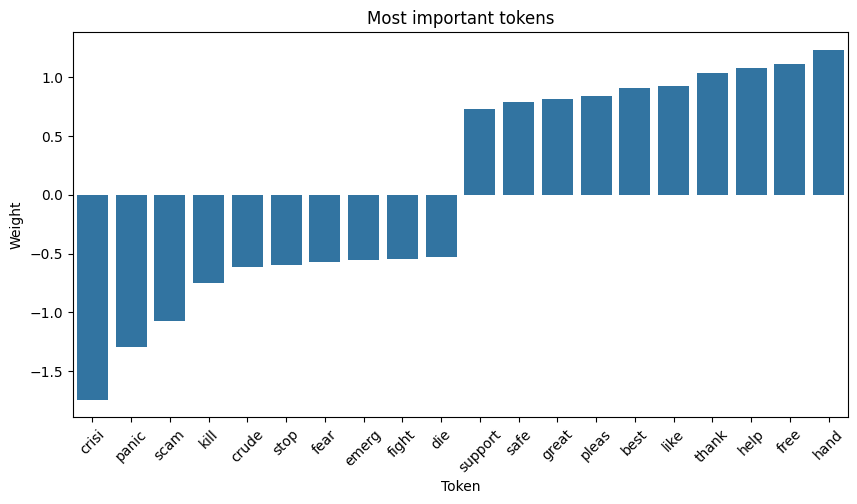

In [47]:
weights = Counter(dict(zip(count_vectorizer.get_feature_names_out(), model_cv.coef_[0])))

important = np.array(weights.most_common()[-1:-11:-1] + weights.most_common(10)[::-1])

ax = plt.figure(figsize=(10, 5)).add_subplot()

sns.barplot(
    x=important[:, 0],
    y=important[:, 1].astype(float),
    ax=ax,
)

ax.set_xlabel("Token")
ax.set_ylabel("Weight")
ax.set_title("Most important tokens")

plt.xticks(rotation=45)
plt.show();

**Ответ:** Accuracy на `train` повысилась, а на `test` $-$ снизилась.

Среди самых весомых токенов как раз самые важные позитивные токены (с весами $> 0$) и самые важные негативные токены (с весами $< 0$).

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [48]:
df["UserName"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 33444 entries, 0 to 33443
Series name: UserName
Non-Null Count  Dtype
--------------  -----
33444 non-null  int64
dtypes: int64(1)
memory usage: 261.4 KB


In [49]:
df["UserName"].describe()

count    33444.000000
mean     24233.721863
std      11875.552641
min       3800.000000
25%      13964.750000
50%      24159.500000
75%      34514.250000
max      44955.000000
Name: UserName, dtype: float64

In [50]:
df["UserName"].value_counts()

UserName
3800     1
3801     1
3802     1
3803     1
3804     1
        ..
44949    1
44950    1
44952    1
44953    1
44955    1
Name: count, Length: 33444, dtype: int64

In [51]:
len(df["UserName"].unique()) == len(df["UserName"])

True

In [52]:
df["ScreenName"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 33444 entries, 0 to 33443
Series name: ScreenName
Non-Null Count  Dtype
--------------  -----
33444 non-null  int64
dtypes: int64(1)
memory usage: 261.4 KB


In [53]:
df["ScreenName"].describe()

count    33444.000000
mean     69185.721863
std      11875.552641
min      48752.000000
25%      58916.750000
50%      69111.500000
75%      79466.250000
max      89907.000000
Name: ScreenName, dtype: float64

In [54]:
df["ScreenName"].value_counts()

ScreenName
48752    1
48753    1
48754    1
48755    1
48756    1
        ..
89901    1
89902    1
89904    1
89905    1
89907    1
Name: count, Length: 33444, dtype: int64

In [55]:
len(df["ScreenName"].unique()) == len(df["ScreenName"])

True

In [56]:
df.sample(10)[["UserName", "ScreenName", "OriginalTweet", "Sentiment"]]

,UserName,ScreenName,OriginalTweet,Sentiment
23426,32419,77371,Governor @GavinNewsom:\r\r\n\r\r\nItÃÂs nece...,1
30716,41579,86531,In the wake of the COVID 19 wreaking havoc acr...,0
20123,28339,73291,@HLiedown The person who abuses the supermarke...,0
1515,5637,50589,Shout out to all the grocery store employees. ...,0
26508,36279,81231,#Grocery prices are rising as eat-at-home dema...,0
30149,40836,85788,Seriously I donÃÂt mind driving an extra mil...,0
3761,8360,53312,"California Launches New Comprehensive, Consume...",1
12084,18456,63408,ÃÂ Me and terry conversation about the #cor...,1
6884,12169,57121,#UnitedKingdom #WestMidland #Coronavirus\r\r\n...,0
916,4902,49854,Online shopping be like Spring It on up to 75 ...,1


**Ответ:** как показало исследование, признаки `UserName` и `ScreenName` являются уникальными для каждого твита из всего датасета, к тому же они и по смыслу не несут полезной информации для определения тональности твитов, а просто идентифицируют автора. Таким образом, использовать для логистической регрессии ни тот, ни другой признак не стоит.

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на основе целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [57]:
df["TweetAt"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 33444 entries, 0 to 33443
Series name: TweetAt
Non-Null Count  Dtype 
--------------  ----- 
33444 non-null  object
dtypes: object(1)
memory usage: 261.4+ KB


In [58]:
df["TweetAt"].describe()

count          33444
unique            30
top       20-03-2020
freq            2851
Name: TweetAt, dtype: object

In [59]:
df["TweetAt"].value_counts()

TweetAt
20-03-2020    2851
19-03-2020    2644
25-03-2020    2455
18-03-2020    2256
21-03-2020    2197
22-03-2020    1733
23-03-2020    1668
17-03-2020    1616
08-04-2020    1516
07-04-2020    1469
06-04-2020    1382
24-03-2020    1196
09-04-2020    1186
13-04-2020    1157
26-03-2020    1014
05-04-2020     896
10-04-2020     766
02-04-2020     753
11-04-2020     727
12-04-2020     657
03-04-2020     656
04-04-2020     637
16-03-2020     548
01-04-2020     505
31-03-2020     274
27-03-2020     265
14-04-2020     224
29-03-2020      97
30-03-2020      77
28-03-2020      22
Name: count, dtype: int64

In [60]:
df["TweetAt"] = pd.to_datetime(df["TweetAt"], format="%d-%m-%Y")

train["TweetAt"] = pd.to_datetime(train["TweetAt"], format="%d-%m-%Y")
test["TweetAt"] = pd.to_datetime(test["TweetAt"], format="%d-%m-%Y")

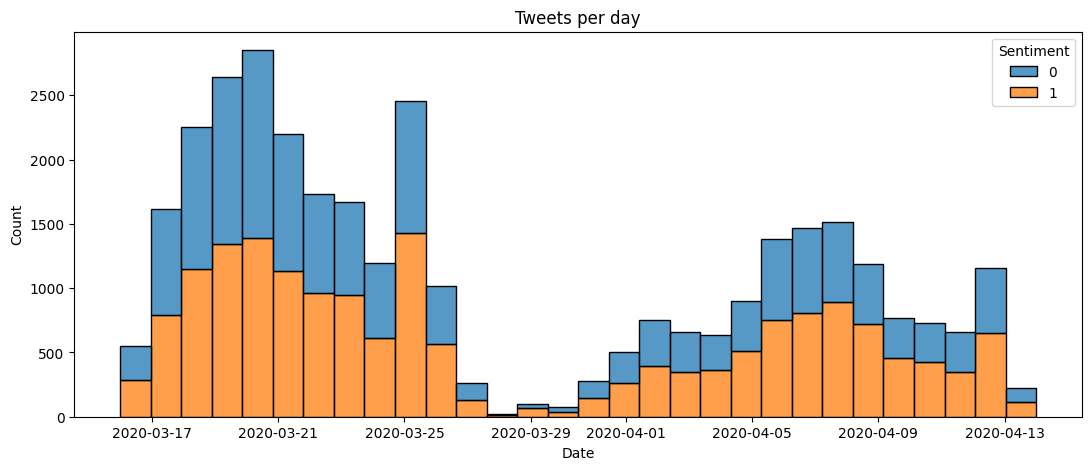

In [61]:
ax = plt.figure(figsize=(13, 5)).add_subplot()

sns.histplot(
    data=df,
    x="TweetAt",
    bins=df["TweetAt"].nunique(),
    hue="Sentiment",
    multiple="stack",
    ax=ax,
)

ax.set_xlabel("Date")
ax.set_ylabel("Count")

ax.set_title("Tweets per day")

plt.show();

In [62]:
train_dummies = pd.get_dummies(train["TweetAt"], dtype=np.int8)
test_dummies = pd.get_dummies(test["TweetAt"], dtype=np.int8)

In [63]:
train_features = hstack_sparse((scaled_cv_features_train, train_dummies))
test_features = hstack_sparse((scaled_cv_features_test, test_dummies))

In [64]:
logreg = LogisticRegression(n_jobs=-1).fit(train_features, y_train) # type: ignore

print(f"Logistic Regression with Count Vectorizer ({len(logreg.coef_[0])} parameters):")
print(f"Accuracy on train: {accuracy_score(y_train, logreg.predict(train_features)):.3f}") # type: ignore
print(f"Accuracy on test: {accuracy_score(y_test, logreg.predict(test_features)):.3f}") # type: ignore

Logistic Regression with Count Vectorizer (3717 parameters):
Accuracy on train: 0.943
Accuracy on test: 0.843


**Ответ:** Признак `TweetAt` оздачает дату публикации твита. Поскольку в разные дни действительно разная интенсивность постов, а уникальных дат всего $30$ во всём датасете, так что добавим признак к модели. Accuracy при этом немного выросла на `train` и немного упала на `test`.

Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [65]:
df["Location"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 33444 entries, 0 to 33443
Series name: Location
Non-Null Count  Dtype 
--------------  ----- 
33444 non-null  object
dtypes: object(1)
memory usage: 261.4+ KB


In [66]:
df["Location"].describe()

count       33444
unique      10465
top       Unknown
freq         7052
Name: Location, dtype: object

In [67]:
df["Location"].value_counts()

Location
Unknown                       7052
London                         435
United States                  416
London, England                413
Washington, DC                 317
                              ... 
Cedar Falls, IA                  1
Parliament House, Canberra       1
Jaipur, Rajasthan                1
BENGALURU                        1
BHAVNAGAR,GUJRAT                 1
Name: count, Length: 10465, dtype: int64

Во всём датасете $10465$ уникальных локаций, из которых пользователи писали посты.

Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

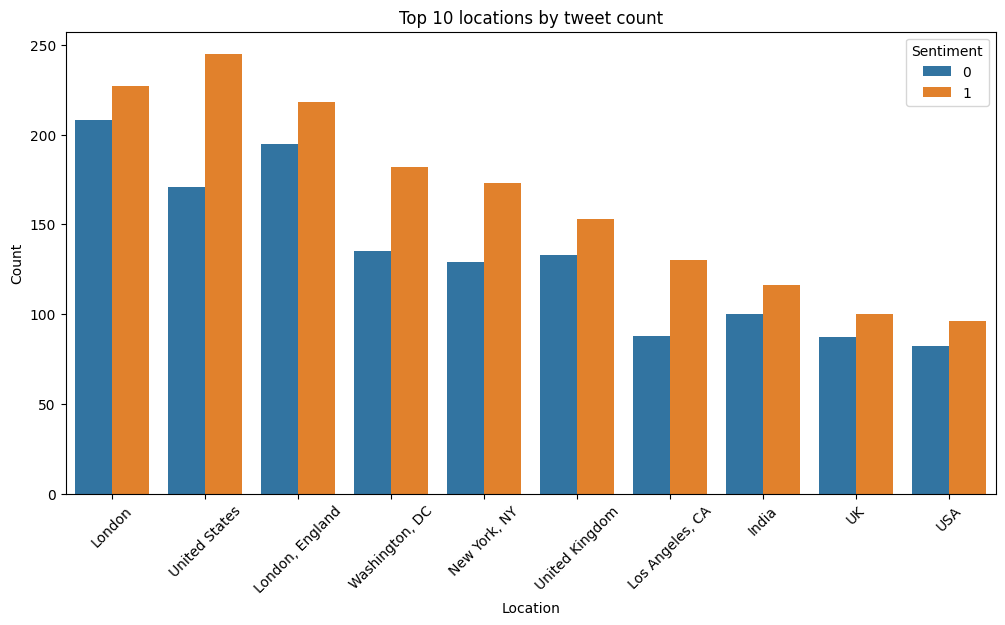

In [68]:
top_locations = df["Location"].value_counts().nlargest(11).index[1:]

ax = plt.figure(figsize=(12, 6)).add_subplot()

sns.countplot(
    data=df[df["Location"].isin(top_locations)],
    x="Location",
    hue="Sentiment",
    order=top_locations,
    ax=ax,
)

ax.set_xlabel("Location")
ax.set_ylabel("Count")

ax.set_title("Top 10 locations by tweet count")

plt.xticks(rotation=45)
plt.show();

Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

In [69]:
df["WiderLocation"] = df["Location"].str.split(",").map(itemgetter(-1))
train["WiderLocation"] = train["Location"].str.split(",").map(itemgetter(-1))
test["WiderLocation"] = test["Location"].str.split(",").map(itemgetter(-1))

In [70]:
df["WiderLocation"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 33444 entries, 0 to 33443
Series name: WiderLocation
Non-Null Count  Dtype 
--------------  ----- 
33444 non-null  object
dtypes: object(1)
memory usage: 261.4+ KB


In [71]:
df["WiderLocation"].describe()

count       33444
unique       6787
top       Unknown
freq         7052
Name: WiderLocation, dtype: object

In [72]:
df["WiderLocation"].value_counts()

WiderLocation
Unknown            7052
 England           1227
 USA               1215
 CA                 850
 India              555
                   ... 
oakland               1
in your dreams        1
tx                    1
Jackson TN            1
Louisville            1
Name: count, Length: 6787, dtype: int64

Было $10465$ уникальных локаций, а после обработки стало значительно меньше $-$ $6787$.

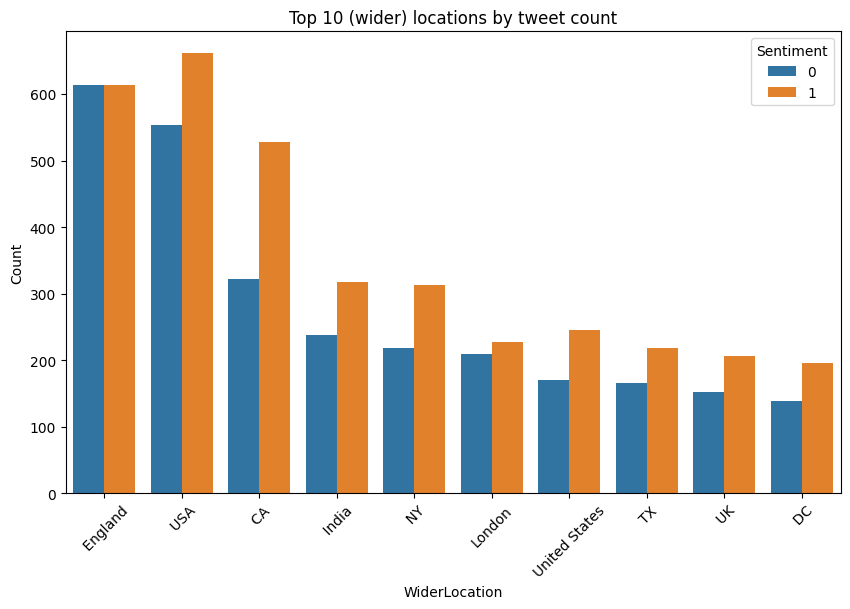

In [73]:
top_locations = df["WiderLocation"].value_counts().nlargest(11).index[1:]

ax = plt.figure(figsize=(10, 6)).add_subplot()

sns.countplot(
    data=df[df["WiderLocation"].isin(top_locations)],
    x="WiderLocation",
    hue="Sentiment",
    order=top_locations,
    ax=ax,
)

ax.set_xlabel("WiderLocation")
ax.set_ylabel("Count")

ax.set_title("Top 10 (wider) locations by tweet count")

plt.xticks(rotation=45)
plt.show();

Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [74]:
encoder = OneHotEncoder(
    min_frequency=2,
    handle_unknown="ignore",
).fit(train[["WiderLocation"]])

In [75]:
(train["WiderLocation"].value_counts() > 1).sum() == len(encoder.categories_[0]) - len(encoder.infrequent_categories_[0]) # type: ignore

np.True_

In [76]:
(df["WiderLocation"].value_counts() > 1).sum()

np.int64(1538)

Во всём датасете $1538$ крупных локаций, из которых минимум два пользователя написали посты.

Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?

In [77]:
train_ohe = encoder.transform(train[["WiderLocation"]]).astype(np.int8) # type: ignore
test_ohe = encoder.transform(test[["WiderLocation"]]).astype(np.int8) # type: ignore

train_features = hstack_sparse([train_features, train_ohe])
test_features = hstack_sparse([test_features, test_ohe])

In [78]:
logreg = LogisticRegression(n_jobs=-1).fit(train_features, y_train) # type: ignore

print(f"Logistic Regression with Count Vectorizer ({len(logreg.coef_[0])} parameters):")
print(f"Accuracy on train: {accuracy_score(y_train, logreg.predict(train_features)):.3f}") # type: ignore
print(f"Accuracy on test: {accuracy_score(y_test, logreg.predict(test_features)):.3f}") # type: ignore

Logistic Regression with Count Vectorizer (4877 parameters):
Accuracy on train: 0.946
Accuracy on test: 0.843


**Ответ:** Признак `WiderLocation` оказался очень слабо полезным $-$ accuracy немного выросла на `train`, но не поменялась на `test`.